# Milestone 2: baseline models
___

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import import_preprocess, baseline_models
from importlib import reload
reload(import_preprocess)
reload(baseline_models)

from import_preprocess import ImportPreprocess, convert_labels_to_string, convert_labels_to_int
from baseline_models import XGBoostClassifier, MajorityClassClassifier, RuleBasedClassifier, NaiveBayesClassifier, LogisticRegression, LSTM_Model, get_all_predictions

In [2]:
import_preprocess = ImportPreprocess()
import_preprocess.import_train_val_test()
import_preprocess.create_balanced_dataset()

X_train, y_train, S_train, y_train_multi = import_preprocess.X_train, import_preprocess.y_train, import_preprocess.S_train, import_preprocess.y_train_multi
X_val, y_val, S_val, y_val_multi = import_preprocess.X_val, import_preprocess.y_val, import_preprocess.S_val, import_preprocess.y_val_multi
X_test, y_test, S_test, y_test_multi = import_preprocess.X_test, import_preprocess.y_test, import_preprocess.S_test, import_preprocess.y_test_multi
X_balanced, y_balanced = import_preprocess.X_train_balanced, import_preprocess.y_train_balanced

print("Number of training samples:", len(X_train)) 
print("Number of validation samples:", len(X_val))
print("Number of test samples:", len(X_test)) 
print("Number of balanced samples:", len(X_balanced))

Number of training samples: 14000
Number of validation samples: 2000
Number of test samples: 4000
Number of balanced samples: 10000


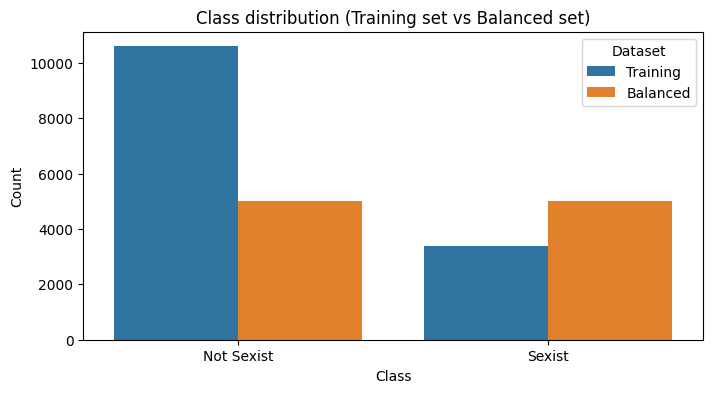

In [3]:
plot_data = pd.DataFrame({
    'Class': ['Not Sexist', 'Sexist'],
    'Training': [y_train.count('not sexist'), y_train.count('sexist')],
    'Balanced': [y_balanced.count('not sexist'), y_balanced.count('sexist')]
})
plot_data_melted = plot_data.melt(id_vars='Class', var_name='Dataset', value_name='Count')
plt.figure(figsize=(8, 4))
sns.barplot(x='Class', y='Count', hue='Dataset', data=plot_data_melted)
plt.title('Class distribution (Training set vs Balanced set)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [4]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall'])

#### a) Traditional (non-DL) baseline models

1. majority class classifier

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.7573
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



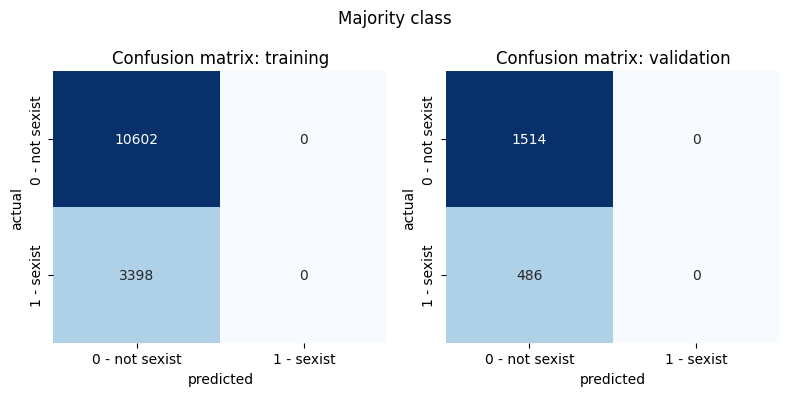

In [5]:
majority_class_classifier = MajorityClassClassifier()
majority_class_classifier.train(None, y_train, None, None)
print(f"Majority class: {majority_class_classifier.majority_class}\n")

res = majority_class_classifier.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="Majority class")
for res_x in res:
    results.loc[len(results)] = res_x

Majority class: not sexist

########################################

Metrics for training
accuracy: 0.5000
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################

Metrics for validation
accuracy: 0.7570
balanced accuracy: 0.5000
precision: 0.0000
recall: 0.0000

########################################



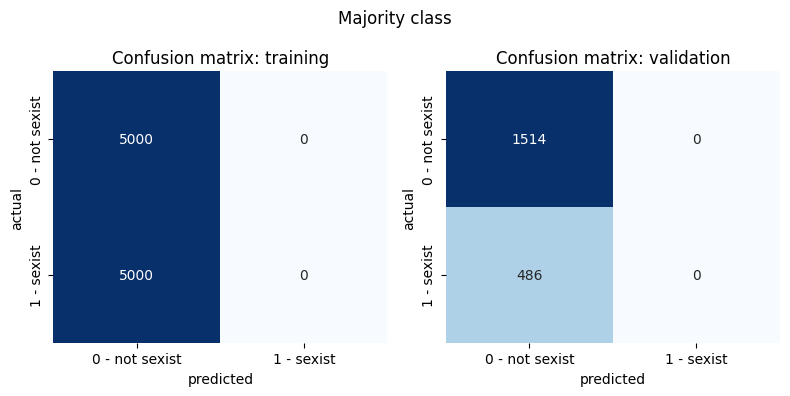

In [6]:
majority_class_classifier_bal = MajorityClassClassifier()
majority_class_classifier_bal.train(None, y_balanced, None, None)
print(f"Majority class: {majority_class_classifier_bal.majority_class}\n")

res = majority_class_classifier_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="Majority class")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

2. regex classifier (rule-based)

########################################

Metrics for training
accuracy: 0.7164
balanced accuracy: 0.5732
precision: 0.3890
recall: 0.2949

########################################

Metrics for validation
accuracy: 0.7075
balanced accuracy: 0.5630
precision: 0.3673
recall: 0.2819

########################################



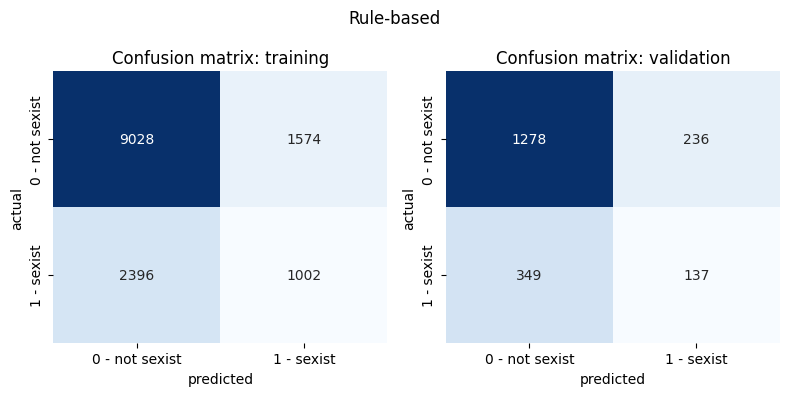

In [7]:
patterns = [
    r"\b(slut|bitch|fuck|fucking|sex)\b",
    r"\b(she has|she has to|she must|she shouldn't|women have to|women must|women shouldn't)\b",
    r"\b(hate|die)\b"
]

regex_classifier = RuleBasedClassifier(patterns)
res = regex_classifier.evaluate({"training": S_train, "validation": S_val}, [y_train, y_val], model_name="Rule-based")
for res_x in res:
    results.loc[len(results)] = res_x

3. Naive Bayes (NB)

########################################

Metrics for training
accuracy: 0.8619
balanced accuracy: 0.7942
precision: 0.7412
recall: 0.6624

########################################

Metrics for validation
accuracy: 0.8095
balanced accuracy: 0.7128
precision: 0.6296
recall: 0.5247

########################################



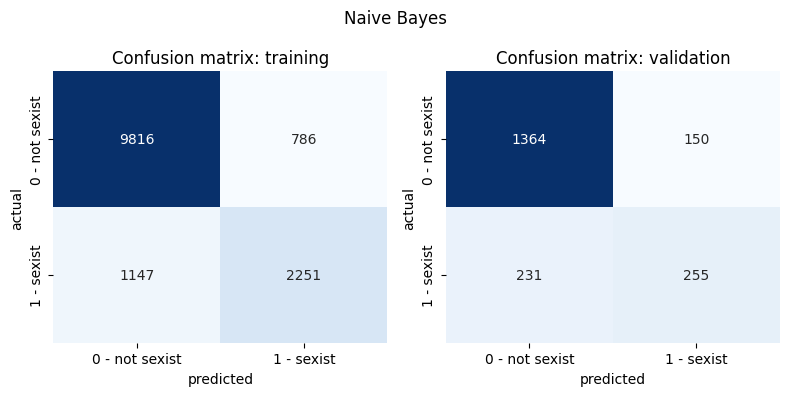

In [8]:
X_train_bow, X_val_bow, X_test_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x

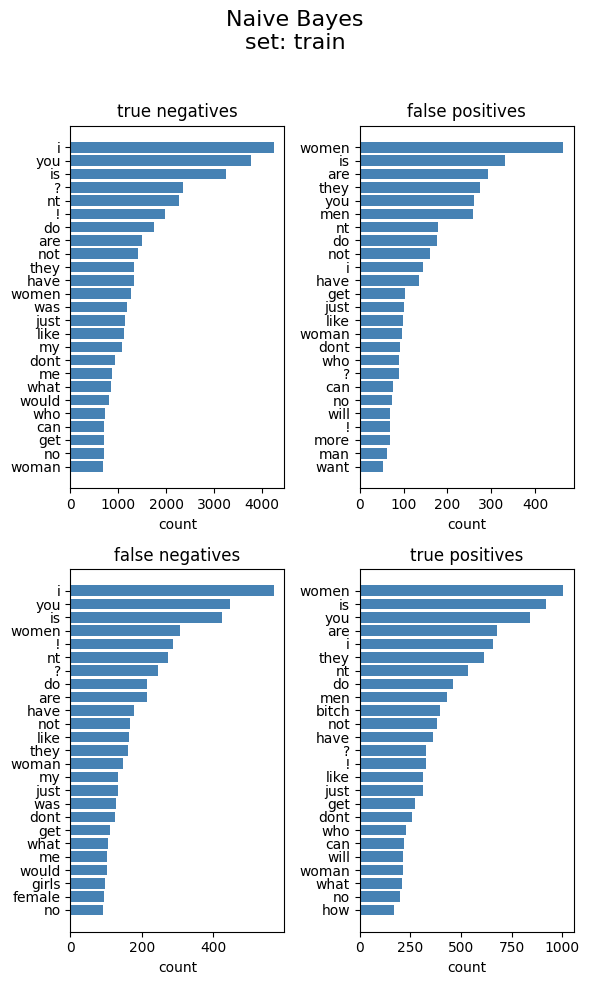

In [9]:
naive_bayes_classifier.qualitative_analysis_top_tokens(X_train, X_train_bow, y_train, set_type="train", model_name="Naive Bayes", plot=True)

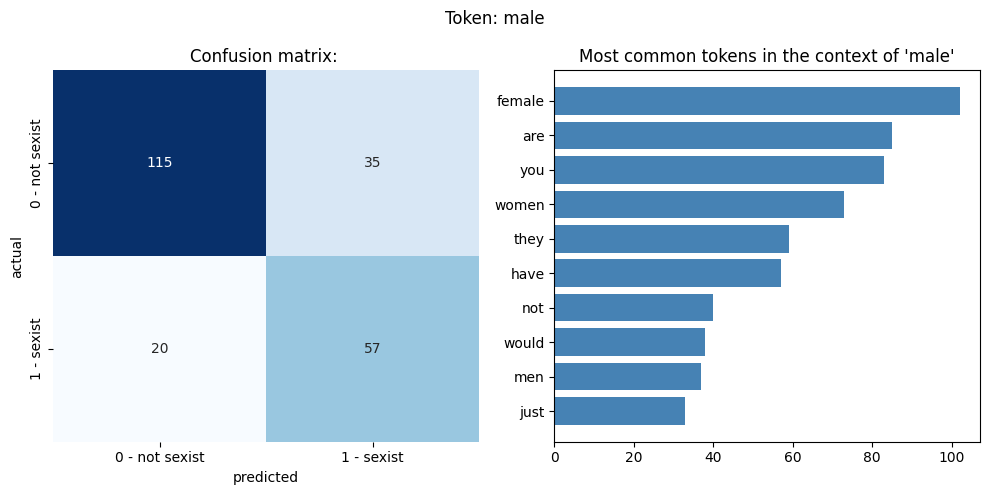

Examples:
Label: not sexist, Prediction: not sexist
Male or female leadership if leaders don't have the interest of the people at heart, it's bound to be a shit show (or a shit hole in this case)

Label: not sexist, Prediction: not sexist
...black and immigrant male students may be disproportionately likely to face sexual misconduct adjudication, often because of accusations made by white women. [URL] [URL] [URL] [URL]

Label: not sexist, Prediction: not sexist
Yeah Im sure people bashing Ghostbusters 2016 had nothing to do with the fact that it was a terrible movie. Also funny how Wonder Woman was well received by both male and female audiences #hmmm [URL]

Label: not sexist, Prediction: not sexist
If someone cheats, male or female they're not a good life partner.

Label: sexist, Prediction: sexist
If you have ANY physical flaws in 2018 as a male then it's fucking over. [Meanwhile there are pig women getting offers from dating sites every single day.] ([URL]



In [10]:
naive_bayes_classifier.get_context_for_token("male", X_train_bow, y_train, X_train, S_train, no_examples=5, return_contexts=False)

########################################

Metrics for training
accuracy: 0.8364
balanced accuracy: 0.8364
precision: 0.8256
recall: 0.8530

########################################

Metrics for validation
accuracy: 0.7190
balanced accuracy: 0.6915
precision: 0.4454
recall: 0.6379

########################################



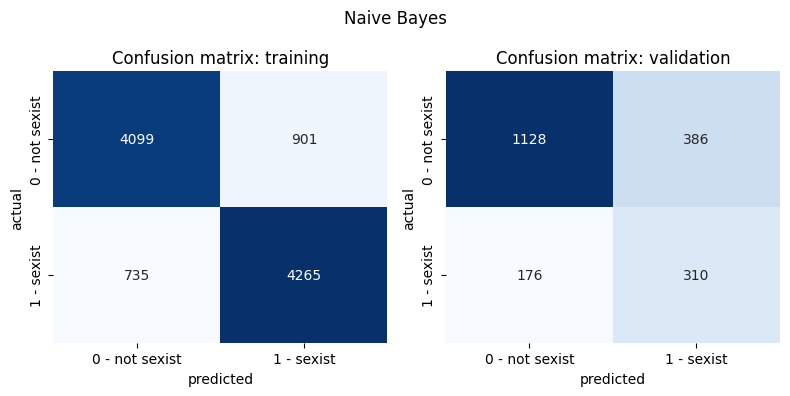

In [11]:
X_train_balanced_bow, X_val_balanced_bow, X_test_balanced_bow, X_train_val_balanced_bow, feature_names = import_preprocess.create_bow_representation(balanced=True)

naive_bayes_classifier_bal = NaiveBayesClassifier()
naive_bayes_classifier_bal.train(X_train_balanced_bow, y_balanced, None, None)

res = naive_bayes_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

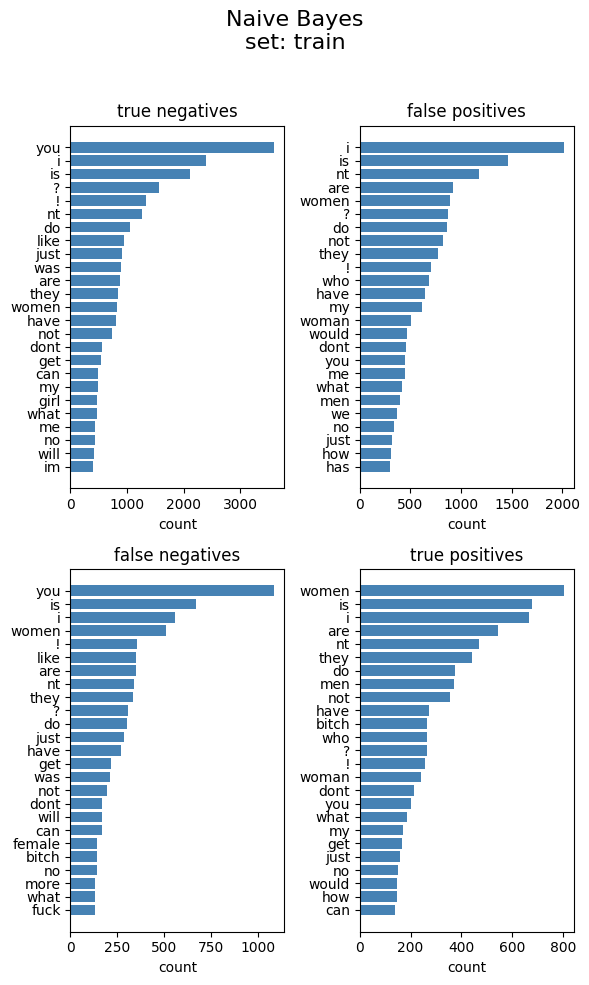

In [12]:
naive_bayes_classifier_bal.qualitative_analysis_top_tokens(X_train, X_train_bow, y_train, set_type="train", model_name="Naive Bayes", plot=True)

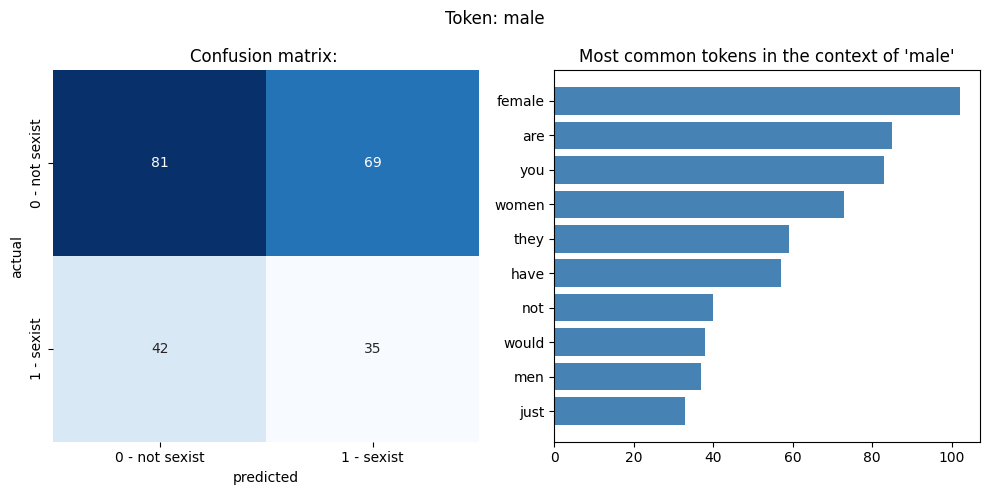

Examples:
Label: sexist, Prediction: not sexist
If a woman says fuck marriage she's "strong and independent" If a man says fuck marriage he's a misogynist and in a cult. Just more misandry and male shaming.

Label: not sexist, Prediction: not sexist
Your brother Evan is mentally ill. Seek help, give the child to a male and female couple. You are born male female...XX or XY. Science is fact.

Label: not sexist, Prediction: sexist
How can she fight crime when she has to be constantly escorted by a male relative?

Label: not sexist, Prediction: sexist
OK. Then why do we see people complaining about women being viewed as "sex objects" and why are people complaining about evil "male fantasies" when sexy women are depicted in a big action movie? You do see that. I'm just saying that's not feminism.

Label: not sexist, Prediction: not sexist
Have sex with your students should get you fired but not thrown in jail male or female, unless it's rape, this is bs



In [13]:
naive_bayes_classifier_bal.get_context_for_token("male", X_train_bow, y_train, X_train, S_train, no_examples=5, return_contexts=False)

4. Logisitic Regression

########################################

Metrics for training
accuracy: 0.8934
balanced accuracy: 0.8052
precision: 0.8964
recall: 0.6339

########################################

Metrics for validation
accuracy: 0.8305
balanced accuracy: 0.7092
precision: 0.7348
recall: 0.4733

########################################



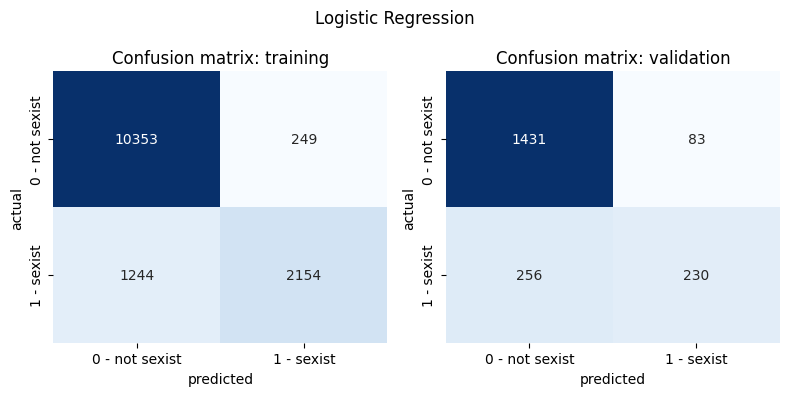

In [14]:
log_reg_classifier = LogisticRegression()
log_reg_classifier.train(X_train_bow, y_train, None, None)

res = log_reg_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Logistic Regression")
for res_x in res:
    results.loc[len(results)] = res_x

########################################

Metrics for training
accuracy: 0.9161
balanced accuracy: 0.9161
precision: 0.9266
recall: 0.9038

########################################

Metrics for validation
accuracy: 0.6370
balanced accuracy: 0.5360
precision: 0.2895
recall: 0.3395

########################################



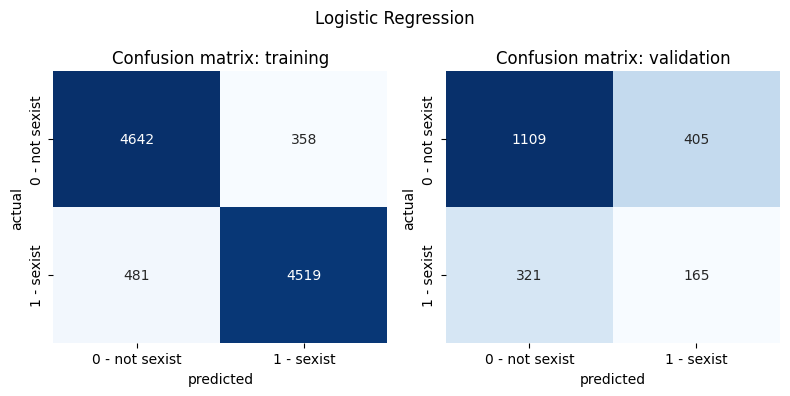

In [15]:
log_reg_classifier_bal = LogisticRegression()
log_reg_classifier_bal.train(X_train_balanced_bow, y_balanced, None, None)

res = log_reg_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_bow}, [y_balanced, y_val], model_name="Logistic Regression")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (using BoW representation)

[0]	train-logloss:0.52937	eval-logloss:0.53489
[1]	train-logloss:0.50975	eval-logloss:0.51887
[2]	train-logloss:0.49416	eval-logloss:0.50663
[3]	train-logloss:0.48118	eval-logloss:0.49671
[4]	train-logloss:0.46994	eval-logloss:0.48861
[5]	train-logloss:0.46077	eval-logloss:0.48165
[6]	train-logloss:0.45331	eval-logloss:0.47542
[7]	train-logloss:0.44618	eval-logloss:0.47046
[8]	train-logloss:0.44031	eval-logloss:0.46619
[9]	train-logloss:0.43467	eval-logloss:0.46229
[10]	train-logloss:0.43020	eval-logloss:0.45909
[11]	train-logloss:0.42613	eval-logloss:0.45672
[12]	train-logloss:0.42236	eval-logloss:0.45474
[13]	train-logloss:0.41823	eval-logloss:0.45253
[14]	train-logloss:0.41514	eval-logloss:0.45026
[15]	train-logloss:0.41209	eval-logloss:0.44859
[16]	train-logloss:0.40948	eval-logloss:0.44689


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[17]	train-logloss:0.40657	eval-logloss:0.44544
[18]	train-logloss:0.40448	eval-logloss:0.44370
[19]	train-logloss:0.40261	eval-logloss:0.44258
[20]	train-logloss:0.40053	eval-logloss:0.44125
[21]	train-logloss:0.39879	eval-logloss:0.43971
[22]	train-logloss:0.39711	eval-logloss:0.43864
[23]	train-logloss:0.39526	eval-logloss:0.43739
[24]	train-logloss:0.39383	eval-logloss:0.43642
[25]	train-logloss:0.39211	eval-logloss:0.43579
[26]	train-logloss:0.39071	eval-logloss:0.43479
[27]	train-logloss:0.38941	eval-logloss:0.43397
[28]	train-logloss:0.38792	eval-logloss:0.43289
[29]	train-logloss:0.38679	eval-logloss:0.43173
[30]	train-logloss:0.38572	eval-logloss:0.43145
[31]	train-logloss:0.38417	eval-logloss:0.43102
[32]	train-logloss:0.38318	eval-logloss:0.43008
[33]	train-logloss:0.38220	eval-logloss:0.42899
[34]	train-logloss:0.38043	eval-logloss:0.42845
[35]	train-logloss:0.37903	eval-logloss:0.42775
[36]	train-logloss:0.37784	eval-logloss:0.42706
[37]	train-logloss:0.37641	eval-logloss:

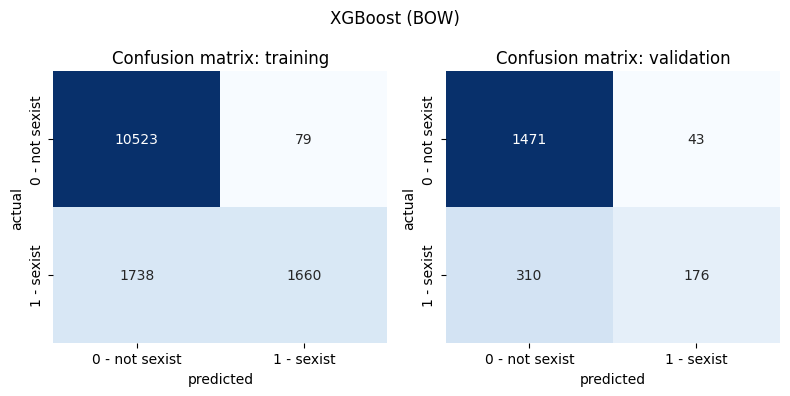

In [16]:
xg_boost_bow = XGBoostClassifier()
xg_boost_bow.train(X_train_bow, y_train, X_val_bow, y_val)

res = xg_boost_bow.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    results.loc[len(results)] = res_x

[0]	train-logloss:0.66377	eval-logloss:0.66906
[1]	train-logloss:0.63995	eval-logloss:0.64973
[2]	train-logloss:0.61993	eval-logloss:0.63397
[3]	train-logloss:0.60332	eval-logloss:0.62094
[4]	train-logloss:0.58837	eval-logloss:0.60977
[5]	train-logloss:0.57627	eval-logloss:0.59993
[6]	train-logloss:0.56513	eval-logloss:0.59109
[7]	train-logloss:0.55561	eval-logloss:0.58385
[8]	train-logloss:0.54742	eval-logloss:0.57736
[9]	train-logloss:0.54005	eval-logloss:0.57195
[10]	train-logloss:0.53319	eval-logloss:0.56681
[11]	train-logloss:0.52752	eval-logloss:0.56198
[12]	train-logloss:0.52248	eval-logloss:0.55760
[13]	train-logloss:0.51802	eval-logloss:0.55454
[14]	train-logloss:0.51379	eval-logloss:0.55151
[15]	train-logloss:0.50993	eval-logloss:0.54866
[16]	train-logloss:0.50614	eval-logloss:0.54608
[17]	train-logloss:0.50249	eval-logloss:0.54331
[18]	train-logloss:0.49887	eval-logloss:0.54140


d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[19]	train-logloss:0.49603	eval-logloss:0.53853
[20]	train-logloss:0.49110	eval-logloss:0.53630
[21]	train-logloss:0.48882	eval-logloss:0.53405
[22]	train-logloss:0.48653	eval-logloss:0.53207
[23]	train-logloss:0.48389	eval-logloss:0.53045
[24]	train-logloss:0.48089	eval-logloss:0.52881
[25]	train-logloss:0.47788	eval-logloss:0.52776
[26]	train-logloss:0.47596	eval-logloss:0.52593
[27]	train-logloss:0.47393	eval-logloss:0.52481
[28]	train-logloss:0.47223	eval-logloss:0.52344
[29]	train-logloss:0.47018	eval-logloss:0.52225
[30]	train-logloss:0.46791	eval-logloss:0.52117
[31]	train-logloss:0.46610	eval-logloss:0.52000
[32]	train-logloss:0.46479	eval-logloss:0.51863
[33]	train-logloss:0.46228	eval-logloss:0.51748
[34]	train-logloss:0.46084	eval-logloss:0.51675
[35]	train-logloss:0.45915	eval-logloss:0.51543
[36]	train-logloss:0.45748	eval-logloss:0.51438
[37]	train-logloss:0.45572	eval-logloss:0.51333
[38]	train-logloss:0.45329	eval-logloss:0.51228
[39]	train-logloss:0.45197	eval-logloss:

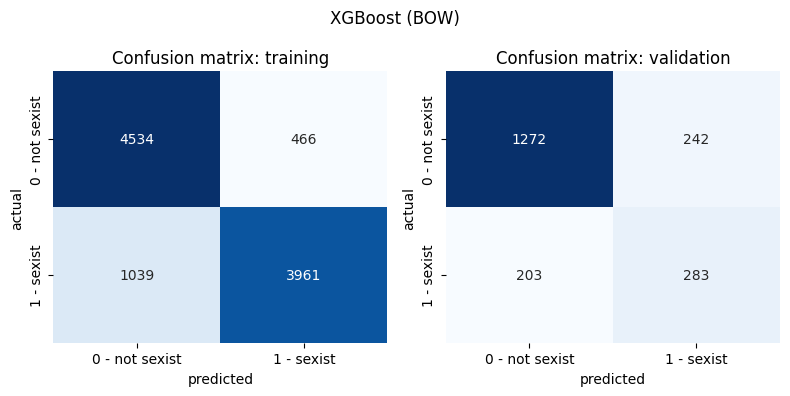

In [17]:
xg_boost_bow_bal = XGBoostClassifier()
xg_boost_bow_bal.train(X_train_balanced_bow, y_balanced, X_val_balanced_bow, y_val)

res = xg_boost_bow_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="XGBoost (BOW)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

5. XGBoost (TF-IDF representation)

d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.52887	eval-logloss:0.53481
[1]	train-logloss:0.50866	eval-logloss:0.51893
[2]	train-logloss:0.49211	eval-logloss:0.50632
[3]	train-logloss:0.47822	eval-logloss:0.49579
[4]	train-logloss:0.46689	eval-logloss:0.48736
[5]	train-logloss:0.45720	eval-logloss:0.48059
[6]	train-logloss:0.44937	eval-logloss:0.47479
[7]	train-logloss:0.44192	eval-logloss:0.47042
[8]	train-logloss:0.43481	eval-logloss:0.46648
[9]	train-logloss:0.42906	eval-logloss:0.46259
[10]	train-logloss:0.42445	eval-logloss:0.45949
[11]	train-logloss:0.41981	eval-logloss:0.45674
[12]	train-logloss:0.41566	eval-logloss:0.45433
[13]	train-logloss:0.41195	eval-logloss:0.45246
[14]	train-logloss:0.40822	eval-logloss:0.45080
[15]	train-logloss:0.40494	eval-logloss:0.44932
[16]	train-logloss:0.40223	eval-logloss:0.44767
[17]	train-logloss:0.39943	eval-logloss:0.44622
[18]	train-logloss:0.39662	eval-logloss:0.44455
[19]	train-logloss:0.39396	eval-logloss:0.44357
[20]	train-logloss:0.39131	eval-logloss:0.44269
[2

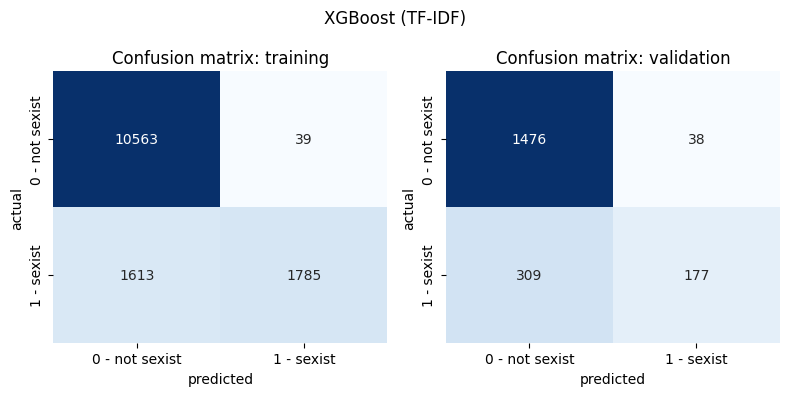

In [18]:
X_train_tfidf, X_val_tfidf, X_test_tfidf, X_train_val_tfidf, feature_names = import_preprocess.create_tfidf_representation()

xg_boost_tfidf = XGBoostClassifier()
xg_boost_tfidf.train(X_train_tfidf, y_train, X_val_tfidf, y_val)

res = xg_boost_tfidf.evaluate({"training": X_train_tfidf, "validation": X_val_tfidf}, [y_train, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    results.loc[len(results)] = res_x

d:\Natural Language Processing\Project new\NLP_24W_VSHJ\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [18:48:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-logloss:0.66329	eval-logloss:0.66902
[1]	train-logloss:0.63848	eval-logloss:0.64871
[2]	train-logloss:0.61814	eval-logloss:0.63113
[3]	train-logloss:0.60085	eval-logloss:0.61722
[4]	train-logloss:0.58502	eval-logloss:0.60512
[5]	train-logloss:0.57177	eval-logloss:0.59511
[6]	train-logloss:0.56021	eval-logloss:0.58660
[7]	train-logloss:0.54967	eval-logloss:0.57969
[8]	train-logloss:0.54078	eval-logloss:0.57326
[9]	train-logloss:0.53324	eval-logloss:0.56797
[10]	train-logloss:0.52649	eval-logloss:0.56300
[11]	train-logloss:0.52040	eval-logloss:0.55847
[12]	train-logloss:0.51463	eval-logloss:0.55473
[13]	train-logloss:0.50956	eval-logloss:0.55116
[14]	train-logloss:0.50458	eval-logloss:0.54779
[15]	train-logloss:0.50038	eval-logloss:0.54441
[16]	train-logloss:0.49296	eval-logloss:0.54121
[17]	train-logloss:0.48953	eval-logloss:0.53835
[18]	train-logloss:0.48588	eval-logloss:0.53567
[19]	train-logloss:0.48227	eval-logloss:0.53349
[20]	train-logloss:0.47901	eval-logloss:0.53103
[2

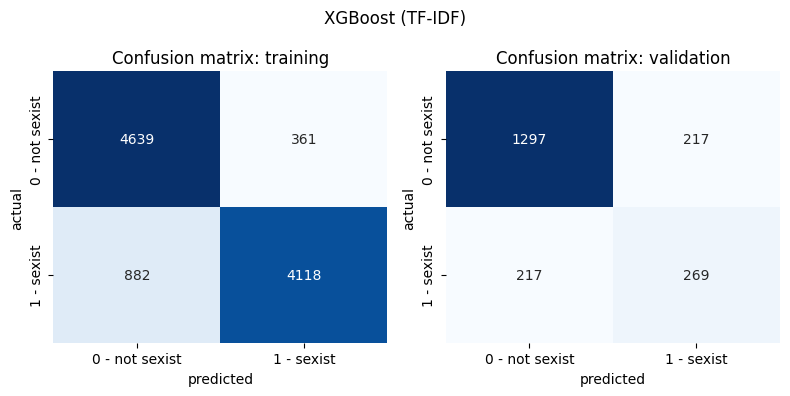

In [19]:
X_train_balanced_tfidf, X_val_balanced_tfidf, X_test_balanced_tfidf, X_train_val_balanced_tfidf, feature_names = import_preprocess.create_tfidf_representation(balanced=True)

xg_boost_tfidf_bal = XGBoostClassifier()
xg_boost_tfidf_bal.train(X_train_balanced_tfidf, y_balanced, X_val_balanced_tfidf, y_val)

res = xg_boost_tfidf_bal.evaluate({"training": X_train_balanced_tfidf, "validation": X_val_balanced_tfidf}, [y_balanced, y_val], model_name="XGBoost (TF-IDF)")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

#### b) DL baseline models

1. LSTM



Epoch 1/200


438/438 [==============================] - 10s 19ms/step - loss: 0.5389 - accuracy: 0.7600 - val_loss: 0.4934 - val_accuracy: 0.7890
Epoch 2/200
438/438 [==============================] - 8s 18ms/step - loss: 0.4324 - accuracy: 0.8201 - val_loss: 0.4469 - val_accuracy: 0.8160
Epoch 3/200
438/438 [==============================] - 8s 18ms/step - loss: 0.3661 - accuracy: 0.8558 - val_loss: 0.4182 - val_accuracy: 0.8265
Epoch 4/200
438/438 [==============================] - 9s 20ms/step - loss: 0.3224 - accuracy: 0.8796 - val_loss: 0.4574 - val_accuracy: 0.8300
Epoch 5/200
438/438 [==============================] - 10s 24ms/step - loss: 0.2869 - accuracy: 0.8971 - val_loss: 0.4130 - val_accuracy: 0.8285
Epoch 6/200
438/438 [==============================] - 13s 29ms/step - loss: 0.2637 - accuracy: 0.9094 - val_loss: 0.4516 - val_accuracy: 0.8165
Epoch 7/200
438/438 [==============================] - 8s 19ms/step - loss: 0.2393 - accuracy: 0.9199 - val_loss: 0.4615 - val_ac

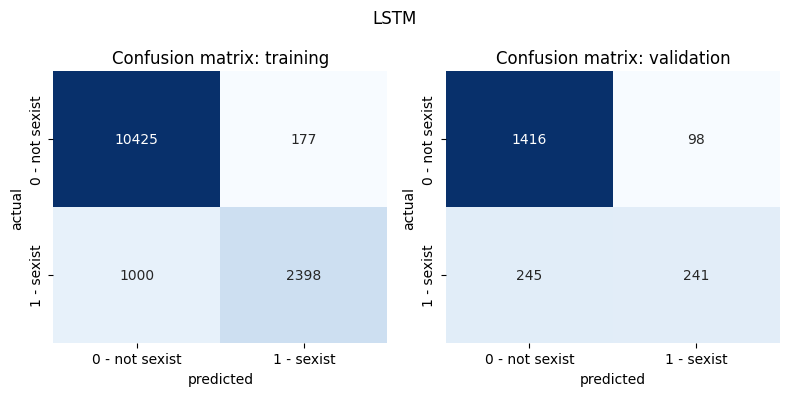

In [20]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

rnn = LSTM_Model()
rnn.train(X_train, y_train, X_val, y_val)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x

438/438 [==============================] - 2s 5ms/step


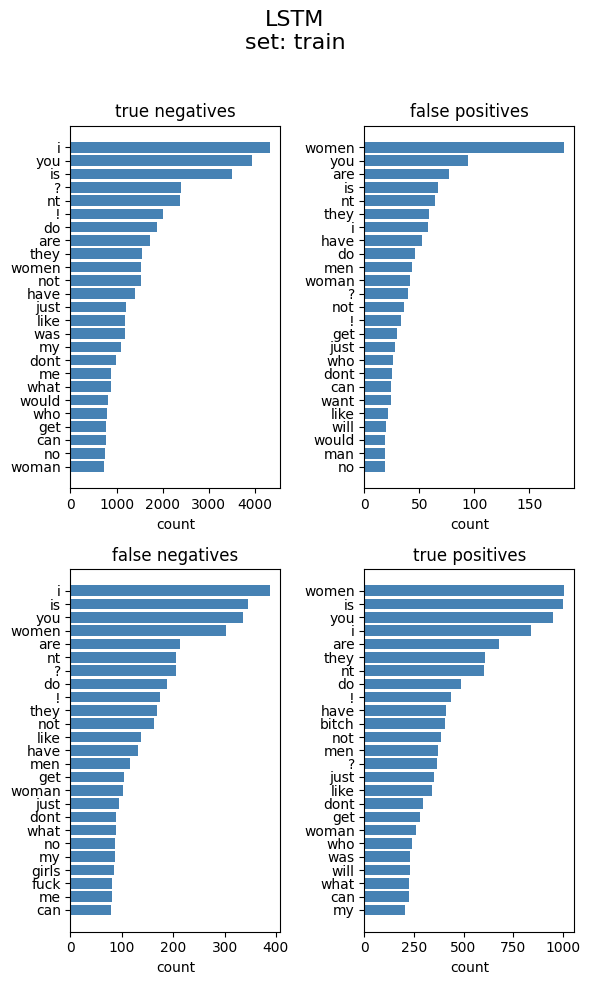

In [21]:
rnn.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="LSTM", plot=True)

438/438 [==============================] - 2s 5ms/step


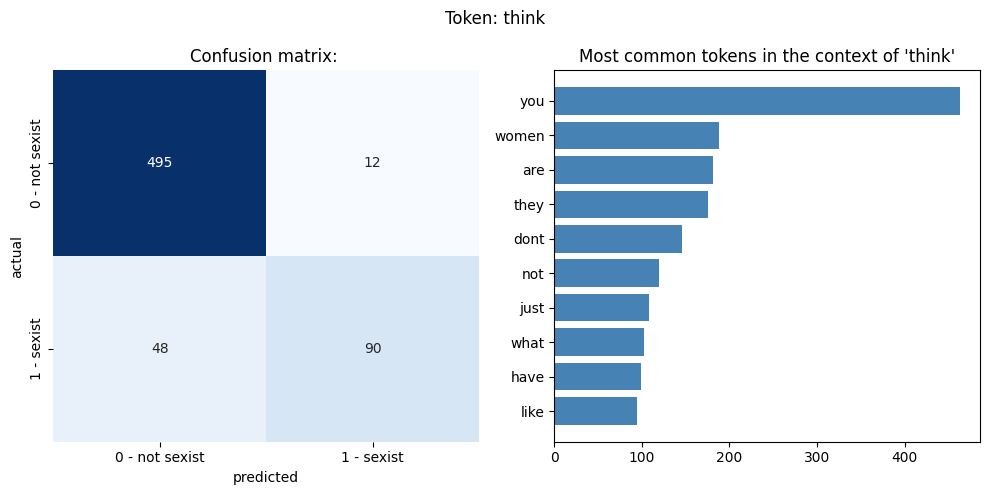

Examples:
Label: not sexist, Prediction: [0]
[USER] I think thats the point [USER] was making, if there are those sealed indictments then lets see them! Also she said WE have suffered enough, we the people, not the swamp assholes, we WANT them to suffer!

Label: sexist, Prediction: [1]
I don't think it is so much that women are unhappy, but claiming they are is a way of making sure that men, who they positively don't need and are superior to, are not doing enough for them.

Label: not sexist, Prediction: [0]
This is hard for me because I am still only a pescatarian, I think I will try in the next few years to move into eating hunted or local meat.. #vargvikernes -#odalism #burzum #thuleanperspective #europe #women #health [URL]

Label: not sexist, Prediction: [0]
sounds like youâre still living in the 1950s. and maybe think about why women have to rest so much while pregnant maybe even ask your mother iâm sure sheâd be disappointed

Label: not sexist, Prediction: [0]
In regards t

In [22]:
rnn.get_context_for_token("think", X_train, y_train, X_train, S_train, no_examples=5, return_contexts=False)

Epoch 1/200
313/313 [==============================] - 7s 20ms/step - loss: 0.6936 - accuracy: 0.5003 - val_loss: 0.6831 - val_accuracy: 0.7570
Epoch 2/200
313/313 [==============================] - 6s 19ms/step - loss: 0.6934 - accuracy: 0.4984 - val_loss: 0.6864 - val_accuracy: 0.7570
Epoch 3/200
313/313 [==============================] - 12s 39ms/step - loss: 0.6933 - accuracy: 0.4997 - val_loss: 0.6926 - val_accuracy: 0.7570
Epoch 4/200
313/313 [==============================] - 6s 19ms/step - loss: 0.6933 - accuracy: 0.5036 - val_loss: 0.6987 - val_accuracy: 0.2430
Epoch 5/200
313/313 [==============================] - 9s 29ms/step - loss: 0.6933 - accuracy: 0.5015 - val_loss: 0.6990 - val_accuracy: 0.2430
Epoch 6/200
313/313 [==============================] - 13s 41ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6874 - val_accuracy: 0.7570
Epoch 7/200
313/313 [==============================] - 13s 41ms/step - loss: 0.6933 - accuracy: 0.4960 - val_loss: 0.6964 - val_accura

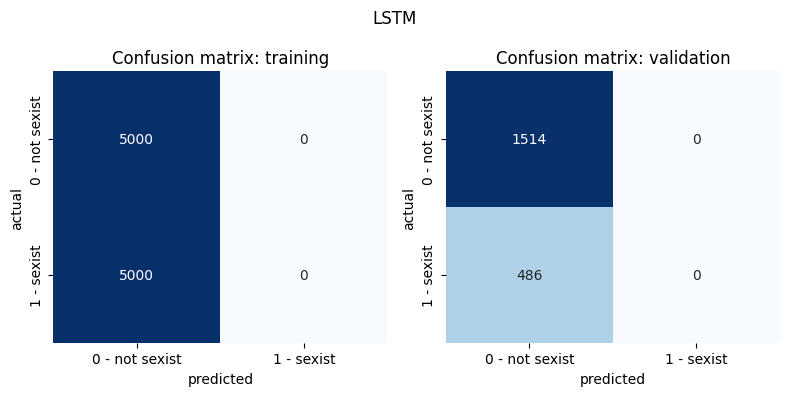

In [23]:
rnn_bal = LSTM_Model()
rnn_bal.train(X_balanced, y_balanced, X_val, y_val)
res = rnn_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x

438/438 [==============================] - 2s 5ms/step


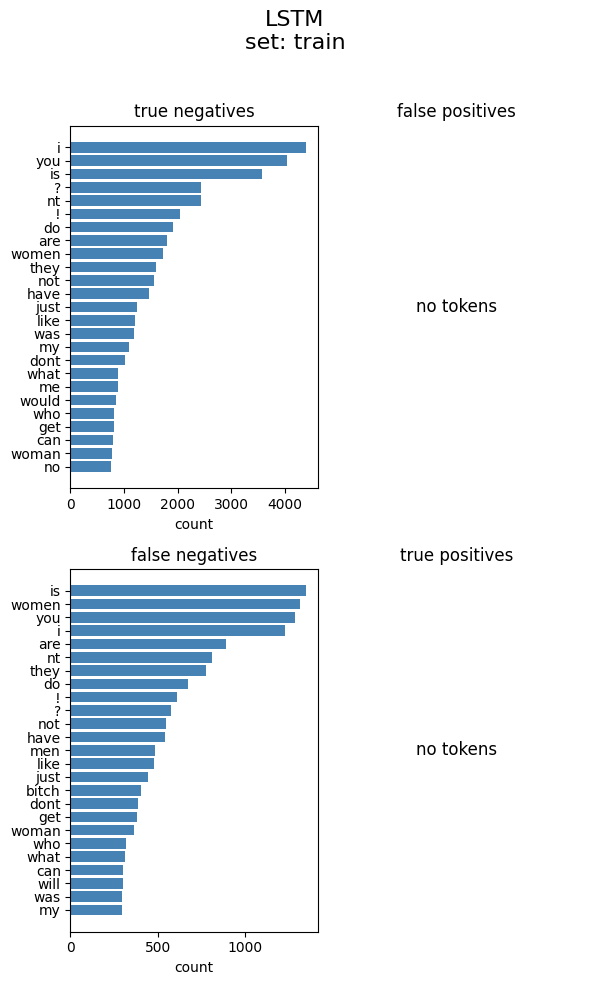

In [24]:
rnn_bal.qualitative_analysis_top_tokens(X_train, X_train, y_train, set_type="train", model_name="LSTM", plot=True)

438/438 [==============================] - 2s 5ms/step


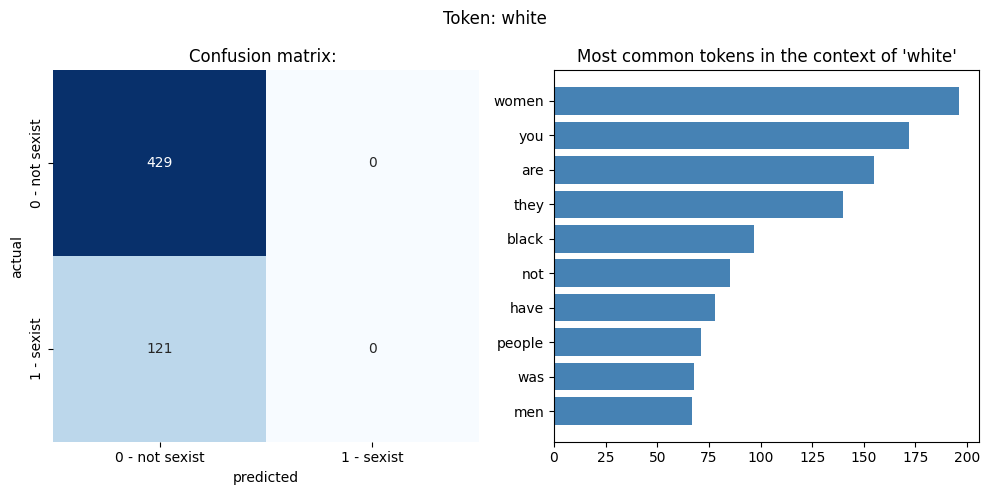

Examples:
Label: not sexist, Prediction: [0]
Yea, consider 6 out of 10 kids cant read english, how long before the old white folks die off. yep this is fine...what a fucking retard [URL]

Label: not sexist, Prediction: [0]
Obviously exceptions made for White men who bust their ass all week long. It's the old German farmer in my bloodline. I'm awake like a shot at 430, 5, regardless.

Label: not sexist, Prediction: [0]
Lizzo wouldnât screw you. When she has access to hot white, black, Asian guys etc.

Label: not sexist, Prediction: [0]
To be clear, is Joy Behar equating Americans, with whom she might disagree politically, peacefully visiting the White House; with foreign agents violently destroying public property? What an idiot.

Label: not sexist, Prediction: [0]
I love how all the idiots and white knights are accusing him of lying because he got the car name wrong. So what. Those cucks really do not want to believe that a woman did something bad.



In [25]:
rnn_bal.get_context_for_token("white", X_train, y_train, X_train, S_train, no_examples=5, return_contexts=False)

## Results

In [26]:
results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.757286,0.500000,0.000000,0.000000
1,Majority class,validation,0.757000,0.500000,0.000000,0.000000
2,Rule-based,training,0.716429,0.573208,0.388975,0.294879
3,Rule-based,validation,0.707500,0.563007,0.367292,0.281893
4,Naive Bayes,training,0.861929,0.794156,0.741192,0.662448
5,Naive Bayes,validation,0.809500,0.712808,0.629630,0.524691
6,Logistic Regression,training,0.893357,0.805208,0.896380,0.633902
7,Logistic Regression,validation,0.830500,0.709215,0.734824,0.473251
8,XGBoost (BOW),training,0.870214,0.740536,0.954572,0.488523
9,XGBoost (BOW),validation,0.823500,0.666869,0.803653,0.362140


In [27]:
balanced_results

,Model,Dataset,Accuracy,Balanced_Accuracy,Precision,Recall
0,Majority class,training,0.5000,0.500000,0.000000,0.000000
1,Majority class,validation,0.7570,0.500000,0.000000,0.000000
2,Naive Bayes,training,0.8364,0.836400,0.825590,0.853000
3,Naive Bayes,validation,0.7190,0.691453,0.445402,0.637860
4,Logistic Regression,training,0.9161,0.916100,0.926594,0.903800
5,Logistic Regression,validation,0.6370,0.536001,0.289474,0.339506
6,XGBoost (BOW),training,0.8495,0.849500,0.894737,0.792200
7,XGBoost (BOW),validation,0.7775,0.711232,0.539048,0.582305
8,XGBoost (TF-IDF),training,0.8757,0.875700,0.919402,0.823600
9,XGBoost (TF-IDF),validation,0.7830,0.705085,0.553498,0.553498


In [28]:
models_dict = {
    "Majority Class": majority_class_classifier,
    "Naive Bayes": naive_bayes_classifier,
    "Logistic Regression": log_reg_classifier,
    "XGBoost (BOW)": xg_boost_bow,
    "LSTM": rnn
}

predictions = get_all_predictions(models_dict, X_val[1], X_val_bow[1], y_val[1])

1/1 [==============================] - 0s 16ms/step


In [29]:
predictions

{'true': 'not sexist',
 'Majority Class': ['not sexist'],
 'Naive Bayes': array(['not sexist'], dtype='<U10'),
 'Logistic Regression': array(['not sexist'], dtype='<U10'),
 'XGBoost (BOW)': ['not sexist'],
 'LSTM': 'not sexist'}

In [30]:
y_pred = rnn.predict(X_val)
y_pred = convert_labels_to_string(y_pred)
y_val = y_val if isinstance(y_val[0], str) else convert_labels_to_string(y_val)

false_negative_indices = [i for i in range(len(X_val)) if y_val[i] == 'sexist' and y_pred[i] == 'not sexist']
false_negative_sentences = [S_val[i] for i in false_negative_indices]
false_negative_sentences

63/63 [==============================] - 0s 4ms/step


['I agree with that but at the same time I know myself well enough to say I canâ\x80\x99t love a woman. The minute she begins to hit the wall and some hotter, younger women enters the picture, itâ\x80\x99s time for impulse control because Iâ\x80\x99m going to want that.',
 "aim for the head so she dosn't come back",
 'until she\'s been around me long enough through real life situations where I can actually see who she really is Like observing her rage when the wifi connection is set to "shit-tier" on the router on purpose. ]=)',
 'Habits are hard to die, as much as the cock carousel she rode all her life.',
 'I am with you on the False Accuser Registry. she does deserve to get raped though. Empathy is dead.',
 'Sheâ\x80\x99s unstable, youâ\x80\x99ll never know when she might dump you or cuck you for the ugliest thug in the nearest gang.',
 'The gun community keeps supporting â\x80\x9cfree market capitalismâ\x80\x9d like a woman returning to her abusive husband.',
 'A woman needs a man 

# Report on Misclassification Analysis of RNN Model

In [31]:
import random
random.seed(1234)
# Predict on the test set
y_pred_test = rnn.predict(X_test)

# Convert predictions and true labels to string format
y_pred_test = convert_labels_to_string(y_pred_test)
y_test = y_test if isinstance(y_test[0], str) else convert_labels_to_string(y_test)

# Identify indices for each confusion matrix quadrant
tp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'sexist']  # True Positives
tn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'not sexist']  # True Negatives
fp_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'not sexist' and y_pred_test[i] == 'sexist']  # False Positives
fn_indices_test = [i for i in range(len(X_test)) if y_test[i] == 'sexist' and y_pred_test[i] == 'not sexist']  # False Negatives

# Randomly sample up to 25 sentences from each quadrant
sampled_tp_test = random.sample(tp_indices_test, min(200, len(tp_indices_test)))
sampled_tn_test = random.sample(tn_indices_test, min(200, len(tn_indices_test)))
sampled_fp_test = random.sample(fp_indices_test, min(200, len(fp_indices_test)))
sampled_fn_test = random.sample(fn_indices_test, min(200, len(fn_indices_test)))

# Extract sentences for sampled indices
sampled_sentences_tp_test = [S_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test = [S_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test = [S_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test = [S_test[i] for i in sampled_fn_test]

# Extract multi labels for sampled indices
sampled_sentences_tp_test_multi_label = [y_test_multi[i] for i in sampled_tp_test]
sampled_sentences_tn_test_multi_label = [y_test_multi[i] for i in sampled_tn_test]
sampled_sentences_fp_test_multi_label = [y_test_multi[i] for i in sampled_fp_test]
sampled_sentences_fn_test_multi_label = [y_test_multi[i] for i in sampled_fn_test]

# Extract labels for sampled indices
sampled_sentences_tp_test_label = [y_test[i] for i in sampled_tp_test]
sampled_sentences_tn_test_label = [y_test[i] for i in sampled_tn_test]
sampled_sentences_fp_test_label = [y_test[i] for i in sampled_fp_test]
sampled_sentences_fn_test_label = [y_test[i] for i in sampled_fn_test]

tp_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_tp_test_multi_label, sampled_sentences_tp_test_label)])
tn_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_tn_test_multi_label, sampled_sentences_tn_test_label)])
fp_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_fp_test_multi_label, sampled_sentences_fp_test_label)])
fn_num_in_agreement = sum([max(set(multi_label), key=multi_label.count)==label for multi_label, label in zip(sampled_sentences_fn_test_multi_label, sampled_sentences_fn_test_label)])

# Print the sampled sentences for analysis
print(f"Sampled True Positives (TP), {tp_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_tp_test, sampled_sentences_tp_test_label, sampled_sentences_tp_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled True Negatives (TN), {tn_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_tn_test, sampled_sentences_tn_test_label, sampled_sentences_tn_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled False Positives (FP), {fp_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_fp_test, sampled_sentences_fp_test_label, sampled_sentences_fp_test_multi_label):
    print(s_y, s_y_multi, sentence)

print(f"\nSampled False Negatives (FN), {fn_num_in_agreement} samples in agreement:")
for sentence, s_y, s_y_multi in zip(sampled_sentences_fn_test, sampled_sentences_fn_test_label, sampled_sentences_fn_test_multi_label):
    print(s_y, s_y_multi, sentence)


125/125 [==============================] - 1s 5ms/step
Sampled True Positives (TP), 189 samples in agreement:
sexist ['sexist', 'sexist', 'sexist'] Indeed, her pussy is drying up per second that simp talks. She will probably get fucked by the babies daddy that night.
sexist ['sexist', 'sexist', 'not sexist'] Hate this smug cunt. Squeezing the life from her with my hands clasped about her neck would be the most worthwhile thing I ever did in my life. Bitch. ð¬ð  (I mean Spectre not Empress ð)
sexist ['sexist', 'sexist', 'sexist'] look at this roastie cunt foid's face It's a picture of a teenage girl. I thought they liked teenage girls? How can a literal child be a roastie already?
sexist ['sexist', 'sexist', 'sexist'] When girls hug, they are continuing to gossip. When guys hug, one of 'em is "going down"...lol
sexist ['not sexist', 'sexist', 'sexist'] LOL that fat girl .... black men cant catch up to us so they are angry ..... sooo black men are angry because they are not marryi

## Overview
We are going into an in depth analysis of the RNN model's misclassifications on the test dataset for a sexism detection task. It categorizes the sentences into four confusion matrix quadrants:
- **True Positives (TP):** Correctly classified as sexist.
- **True Negatives (TN):** Correctly classified as not sexist.
- **False Positives (FP):** Incorrectly classified as sexist.
- **False Negatives (FN):** Incorrectly classified as not sexist.

With this analysis we identify patterns in the misclassified samples and suggests improvements to enhance the model's performance.

---

## True Positives (TP)

### **Characteristics:**
- These sentences contain overt sexism, including:
  - Explicit slurs (e.g., "cunt," "bitch," "whore").
  - Objectifying women (e.g., "like a walking dildo").
  - Hostility towards women in power or feminists (e.g., "Fuck this stupid woman").
  - Stereotypes of traditional gender roles (e.g., "Don’t let women vote").

### **Patterns:**
- Use of explicit misogynistic slurs.
- Contextual misogyny targeting gender roles or political affiliations.
- Common references to male-dominant ideologies like MGTOW.

### **Examples:**
- "The sad reality is without sex, men don’t need or want women. But women desire and crave male attention, that’s why they are constantly invading and taking over male spaces."
- "That ho is nothing but a cat's full little box throw her to the dump!"
- "Wow, cheating is so easy and natural for women, that even women in their 80s can do it."

---

## True Negatives (TN)

### **Characteristics:**
- These sentences do not contain sexism and were correctly identified as not sexist.
- They include:
  - Neutral personal reflections (e.g., "My life is filled with things I love: video games, soccer, backpacking trips").
  - Discussions about unrelated topics (e.g., "Quality? I don’t know about you but Cap’s gay ass little arm shields ruined it for me").
  - Sarcastic or humorous comments unrelated to sexism.

### **Patterns:**
- Neutral language and context unrelated to sexism.
- Sarcasm or humor that lacks hostile undertones.
- Discussions focusing on non gender related issues.

### **Examples:**
- "LOL, a Canadian guy legally changed his gender to female so that he would save $1000 a year on car insurance."
- "Normal and normal, girls just don't find me attractive."
- "She stopped responding because there are probably 17 other guys talking to her at the same moment."

---

## False Positives (FP)

### **Characteristics:**
- Sentences incorrectly classified as sexist, possibly due to:
  - The presence of controversial or vulgar language.
  - Discussions of gender dynamics in neutral or balanced ways.
  - General references to feminists, MGTOW, or gendered terms (e.g., "Trouble with MGTOW is you take isolated incidents and judge all females like this").

### **Patterns:**
- Sentences discussing gender-related topics neutrally.
- Vulgar language unrelated to sexism (e.g., "Check the constitution, mother fucker").
- Balanced critique or reflections on societal issues involving gender.

### **Examples:**
- "You can’t get women because you have a shit personality. Maybe you are just creepy and it turns women away."
- "Women should be the first test group. No. They don't think that women should be the 'first test group.'"
- "Having a low sex drive to the point of being practically asexual is such a blessing... women have literally no effect or control over me."

### **Potential Causes:**
- Over-sensitivity to keywords like "women," "feminists," or "MGTOW."
- Lack of contextual understanding in distinguishing neutral discussions from sexism.

---

## False Negatives (FN)

### **Characteristics:**
- Sentences that contain sexism but were misclassified as not sexist.
- Often include:
  - Subtle or euphemistic sexism (e.g., "Women seemingly have endless amounts of time to waste").
  - Stereotypical gender roles (e.g., "Women talk for the sake of talking").
  - Sarcasm or coded language (e.g., "Chad is also catching regret rape claims later").

### **Patterns:**
- Subtle misogyny masked by indirect or sarcastic language.
- Stereotypical comments that lack explicit slurs but imply sexism.
- Euphemistic or metaphorical references to sexism.

### **Examples:**
- "This shows that there ain’t a limit to stupidity for females."
- "The boys should be killed. OK, now that we have that out of the way, why is a girl meeting two boys in a ditch to buy a knife?"

### **Potential Causes:**
- Lack of nuanced understanding of indirect sexism.
- Failure to detect sarcasm or rhetorical devices.

---

# Testing on custom sentences using RNN

In [66]:
import preprocess_input
reload(preprocess_input)
from preprocess_input import preprocess_single_sentence

user_input_sentence = input("Please enter a sentence: ")

processed_text = preprocess_single_sentence(user_input_sentence)

tokens = processed_text.split()

X_input = [tokens]

print("Final input format for RNN predict:", X_input)

prediction = rnn_bal.predict(X_input)

threshold = 0.5
predicted_class = "sexist" if prediction[0][0] >= threshold else "not sexist"

print(f"Prediction: {predicted_class}")


/home/henry/Documents/SharedDocuments/Uni/TU/3.Semester/NLP/.venv/lib/python3.10/site-packages/stanza/models/tokenization/trainer.py:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental f

Hello
Final input format for RNN predict: [['woman', 'should', 'not', 'have', 'right', 'vote']]
1/1 [==============================] - 0s 13ms/step
Prediction: sexist


I think women belong in the kitchen -> sexist
I don't think women belong in the kitchen -> not sexist
I think forks belong in the kitchen -> not sexist
I don't think forks belong in the kitchen -> not sexist

Women should have the right to vote -> sexist
Women shouldn't have the right to vote -> sexist

___
## Different methods of aggregating original labels from 3 annotators

(idea discussed at the review meeting)
___



In [3]:
results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'Aggregation Type'])
balanced_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Balanced_Accuracy', 'Precision', 'Recall', 'Aggregation Type'])

**1. original dataset (aggregation done by dataset creators)**

Let's just summarize what we've covered so far (only NB and LSTM).

- Naive Bayes

########################################

Metrics for training
accuracy: 0.8619
balanced accuracy: 0.7942
precision: 0.7412
recall: 0.6624

########################################

Metrics for validation
accuracy: 0.8095
balanced accuracy: 0.7128
precision: 0.6296
recall: 0.5247

########################################



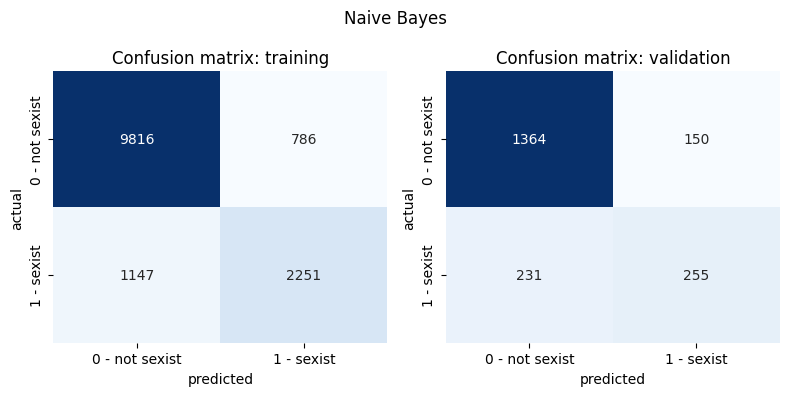

In [4]:
X_train_bow, X_val_bow, X_test_bow, X_train_val_bow, feature_names = import_preprocess.create_bow_representation()

naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train, y_val], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x + ['original']

########################################

Metrics for training
accuracy: 0.8318
balanced accuracy: 0.8318
precision: 0.8210
recall: 0.8486

########################################

Metrics for validation
accuracy: 0.7030
balanced accuracy: 0.6753
precision: 0.4242
recall: 0.6214

########################################



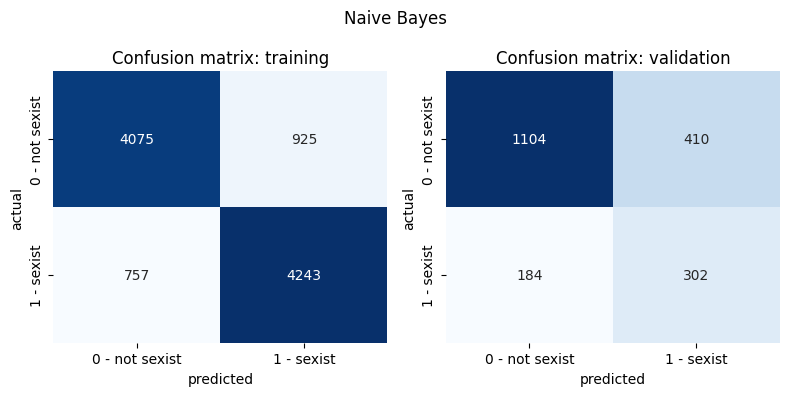

In [5]:
X_train_balanced_bow, X_val_balanced_bow, X_test_balanced_bow, X_train_val_balanced_bow, feature_names = import_preprocess.create_bow_representation(balanced=True)

naive_bayes_classifier_bal = NaiveBayesClassifier()
naive_bayes_classifier_bal.train(X_train_balanced_bow, y_balanced, None, None)

res = naive_bayes_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_balanced, y_val], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['original']

- LSTM



Epoch 1/200


438/438 [==============================] - 10s 21ms/step - loss: 0.5392 - accuracy: 0.7606 - val_loss: 0.4966 - val_accuracy: 0.7835
Epoch 2/200
438/438 [==============================] - 12s 28ms/step - loss: 0.4418 - accuracy: 0.8145 - val_loss: 0.4419 - val_accuracy: 0.8150
Epoch 3/200
438/438 [==============================] - 13s 30ms/step - loss: 0.3626 - accuracy: 0.8610 - val_loss: 0.4678 - val_accuracy: 0.8220
Epoch 4/200
438/438 [==============================] - 13s 29ms/step - loss: 0.3180 - accuracy: 0.8805 - val_loss: 0.4402 - val_accuracy: 0.8175
Epoch 5/200
438/438 [==============================] - 14s 31ms/step - loss: 0.2867 - accuracy: 0.8976 - val_loss: 0.4456 - val_accuracy: 0.8055
Epoch 6/200
438/438 [==============================] - 14s 31ms/step - loss: 0.2561 - accuracy: 0.9118 - val_loss: 0.4645 - val_accuracy: 0.8265
Epoch 7/200
438/438 [==============================] - 13s 29ms/step - loss: 0.2289 - accuracy: 0.9260 - val_loss: 0.5045 - va

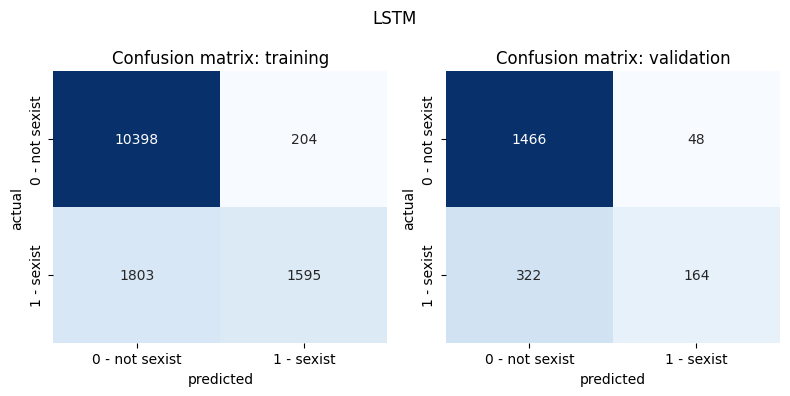

In [6]:
y_train = convert_labels_to_int(y_train)
y_balanced = convert_labels_to_int(y_balanced)
y_val = convert_labels_to_int(y_val)

rnn = LSTM_Model()
rnn.train(X_train, y_train, X_val, y_val)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train, y_val], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x + ['original']

Epoch 1/200
313/313 [==============================] - 7s 19ms/step - loss: 0.6936 - accuracy: 0.4969 - val_loss: 0.6802 - val_accuracy: 0.7570
Epoch 2/200
313/313 [==============================] - 6s 20ms/step - loss: 0.6934 - accuracy: 0.4969 - val_loss: 0.6956 - val_accuracy: 0.2435
Epoch 3/200
313/313 [==============================] - 7s 23ms/step - loss: 0.6931 - accuracy: 0.5064 - val_loss: 0.7000 - val_accuracy: 0.2430
Epoch 4/200
313/313 [==============================] - 6s 19ms/step - loss: 0.6933 - accuracy: 0.4856 - val_loss: 0.6972 - val_accuracy: 0.2430
Epoch 5/200
313/313 [==============================] - 6s 19ms/step - loss: 0.6933 - accuracy: 0.4981 - val_loss: 0.6890 - val_accuracy: 0.7570
Epoch 6/200
313/313 [==============================] - 6s 19ms/step - loss: 0.6933 - accuracy: 0.4898 - val_loss: 0.6949 - val_accuracy: 0.2430
Epoch 7/200
313/313 [==============================] - 6s 19ms/step - loss: 0.6933 - accuracy: 0.4958 - val_loss: 0.6938 - val_accuracy:

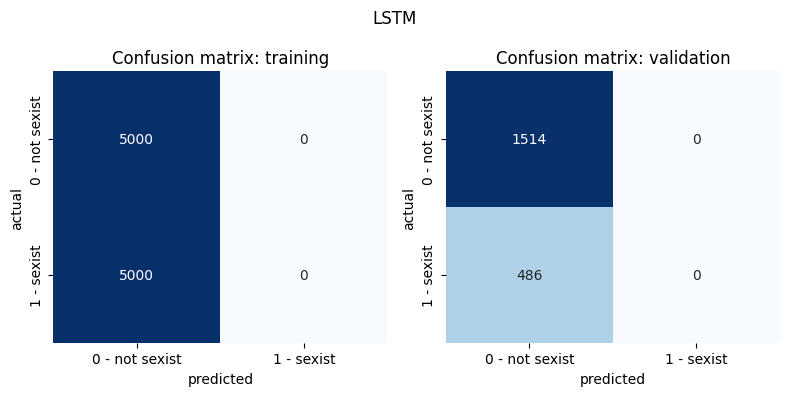

In [7]:
rnn_bal = LSTM_Model()
rnn_bal.train(X_balanced, y_balanced, X_val, y_val)
res = rnn_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_balanced, y_val], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['original']

**2. majority voting**

In [8]:
y_train_mv, y_train_balanced_mv, y_val_mv, y_test_mv = import_preprocess.apply_aggregation(aggregation_type='majority voting')

- Naive Bayes

########################################

Metrics for training
accuracy: 0.8573
balanced accuracy: 0.7883
precision: 0.7312
recall: 0.6539

########################################

Metrics for validation
accuracy: 0.8160
balanced accuracy: 0.7203
precision: 0.6377
recall: 0.5365

########################################



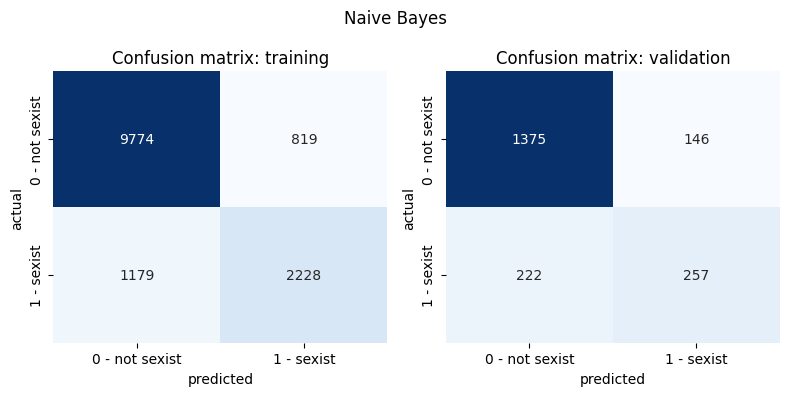

In [9]:
naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train_mv, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train_mv, y_val_mv], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x + ['majority voting']

########################################

Metrics for training
accuracy: 0.8365
balanced accuracy: 0.8357
precision: 0.8210
recall: 0.8251

########################################

Metrics for validation
accuracy: 0.7280
balanced accuracy: 0.6874
precision: 0.4499
recall: 0.6096

########################################



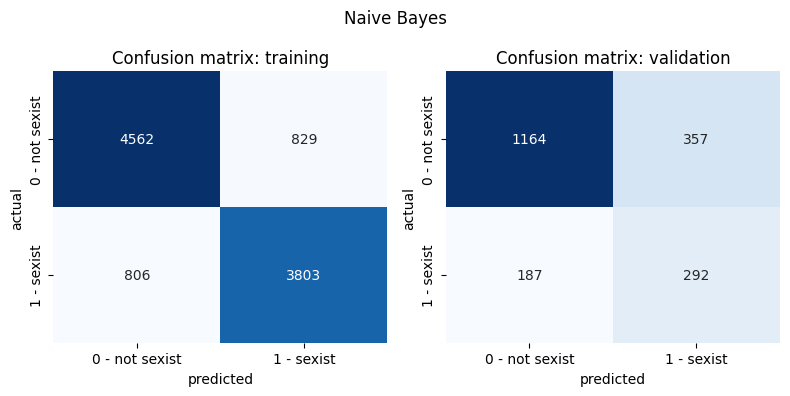

In [10]:
naive_bayes_classifier_bal = NaiveBayesClassifier()
naive_bayes_classifier_bal.train(X_train_balanced_bow, y_train_balanced_mv, None, None)

res = naive_bayes_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_train_balanced_mv, y_val_mv], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['majority voting']

- LSTM

Epoch 1/200
438/438 [==============================] - 15s 32ms/step - loss: 0.5519 - accuracy: 0.7562 - val_loss: 0.5109 - val_accuracy: 0.7735
Epoch 2/200
438/438 [==============================] - 10s 23ms/step - loss: 0.4688 - accuracy: 0.7974 - val_loss: 0.4742 - val_accuracy: 0.7815
Epoch 3/200
438/438 [==============================] - 9s 22ms/step - loss: 0.3809 - accuracy: 0.8497 - val_loss: 0.4381 - val_accuracy: 0.8250
Epoch 4/200
438/438 [==============================] - 12s 28ms/step - loss: 0.3410 - accuracy: 0.8677 - val_loss: 0.4130 - val_accuracy: 0.8315
Epoch 5/200
438/438 [==============================] - 18s 41ms/step - loss: 0.3091 - accuracy: 0.8859 - val_loss: 0.4477 - val_accuracy: 0.8105
Epoch 6/200
438/438 [==============================] - 19s 43ms/step - loss: 0.2808 - accuracy: 0.8997 - val_loss: 0.4242 - val_accuracy: 0.8235
Epoch 7/200
438/438 [==============================] - 19s 43ms/step - loss: 0.2592 - accuracy: 0.9095 - val_loss: 0.4263 - val_acc

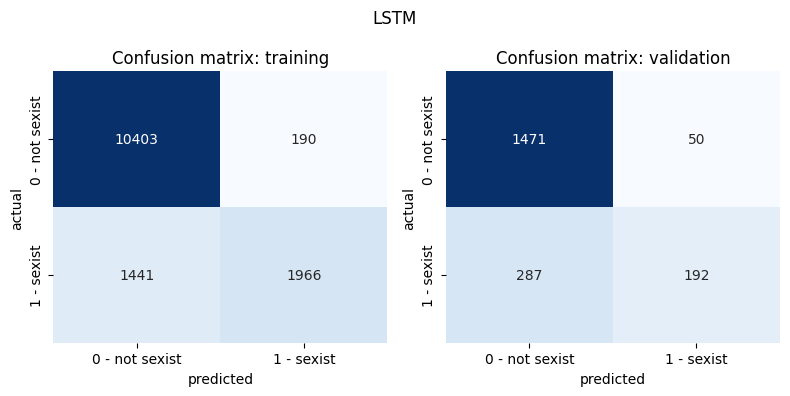

In [12]:
y_train_mv = convert_labels_to_int(y_train_mv)
y_train_balanced_mv = convert_labels_to_int(y_train_balanced_mv)
y_val_mv = convert_labels_to_int(y_val_mv)

rnn = LSTM_Model()
rnn.train(X_train, y_train_mv, X_val, y_val_mv)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train_mv, y_val_mv], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x + ['majority voting']

Epoch 1/200
313/313 [==============================] - 7s 19ms/step - loss: 0.6908 - accuracy: 0.5391 - val_loss: 0.6520 - val_accuracy: 0.7605
Epoch 2/200
313/313 [==============================] - 6s 18ms/step - loss: 0.6904 - accuracy: 0.5391 - val_loss: 0.6458 - val_accuracy: 0.7605
Epoch 3/200
313/313 [==============================] - 6s 19ms/step - loss: 0.6540 - accuracy: 0.6087 - val_loss: 0.5264 - val_accuracy: 0.7650
Epoch 4/200
313/313 [==============================] - 6s 18ms/step - loss: 0.4578 - accuracy: 0.8016 - val_loss: 0.5584 - val_accuracy: 0.7515
Epoch 5/200
313/313 [==============================] - 6s 18ms/step - loss: 0.3270 - accuracy: 0.8747 - val_loss: 0.4867 - val_accuracy: 0.7935
Epoch 6/200
313/313 [==============================] - 9s 30ms/step - loss: 0.2549 - accuracy: 0.9089 - val_loss: 0.5652 - val_accuracy: 0.7435
Epoch 7/200
313/313 [==============================] - 13s 41ms/step - loss: 0.2105 - accuracy: 0.9295 - val_loss: 0.6510 - val_accuracy

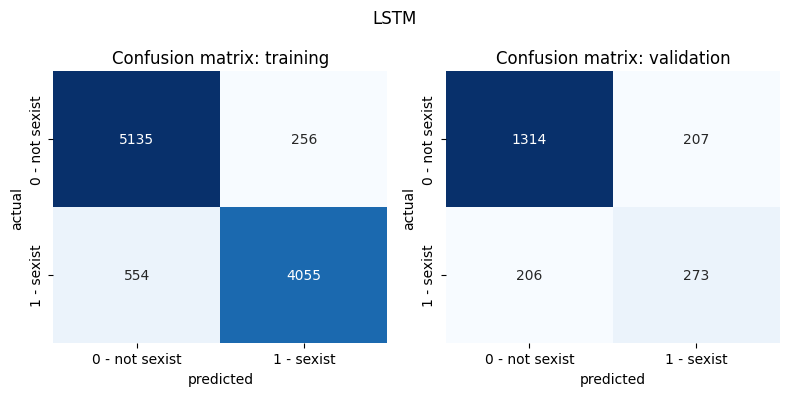

In [13]:
rnn_bal = LSTM_Model()
rnn_bal.train(X_balanced, y_train_balanced_mv, X_val, y_val_mv)

res = rnn_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_train_balanced_mv, y_val_mv], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['majority voting']

**3. at least one sexist**

In [14]:
y_train_alos, y_train_balanced_alos, y_val_alos, y_test_alos = import_preprocess.apply_aggregation(aggregation_type='at least one sexist')

- Naive Bayes

########################################

Metrics for training
accuracy: 0.7944
balanced accuracy: 0.7767
precision: 0.7340
recall: 0.7063

########################################

Metrics for validation
accuracy: 0.7240
balanced accuracy: 0.6900
precision: 0.6189
recall: 0.5734

########################################



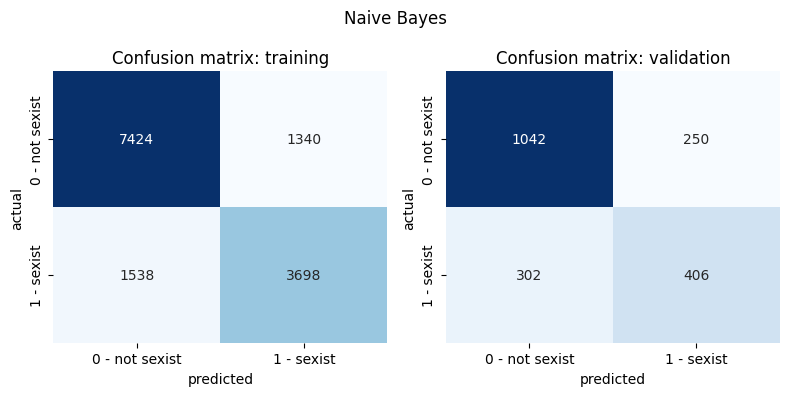

In [15]:
naive_bayes_classifier = NaiveBayesClassifier()
naive_bayes_classifier.train(X_train_bow, y_train_alos, None, None)

res = naive_bayes_classifier.evaluate({"training": X_train_bow, "validation": X_val_bow}, [y_train_alos, y_val_alos], model_name="Naive Bayes")
for res_x in res:
    results.loc[len(results)] = res_x + ['at least one sexist']

########################################

Metrics for training
accuracy: 0.8165
balanced accuracy: 0.8060
precision: 0.8277
recall: 0.8672

########################################

Metrics for validation
accuracy: 0.6450
balanced accuracy: 0.6547
precision: 0.4990
recall: 0.6879

########################################



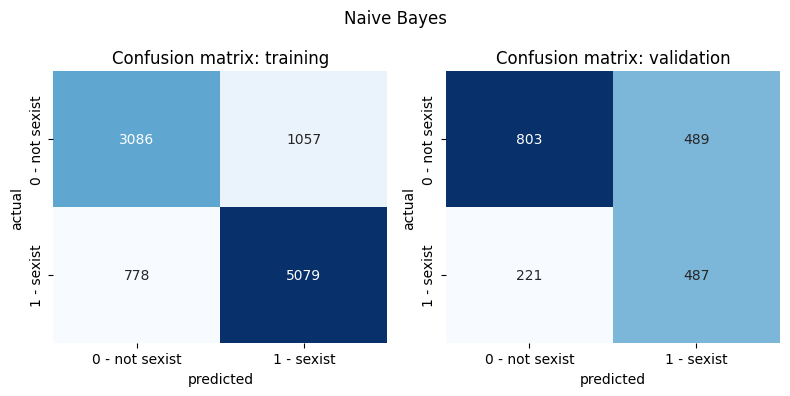

In [16]:
naive_bayes_classifier_bal = NaiveBayesClassifier()
naive_bayes_classifier_bal.train(X_train_balanced_bow, y_train_balanced_alos, None, None)

res = naive_bayes_classifier_bal.evaluate({"training": X_train_balanced_bow, "validation": X_val_balanced_bow}, [y_train_balanced_alos, y_val_alos], model_name="Naive Bayes")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['at least one sexist']

- LSTM

Epoch 1/200
438/438 [==============================] - 10s 21ms/step - loss: 0.6387 - accuracy: 0.6484 - val_loss: 0.5759 - val_accuracy: 0.7075
Epoch 2/200
438/438 [==============================] - 9s 21ms/step - loss: 0.5372 - accuracy: 0.7489 - val_loss: 0.5504 - val_accuracy: 0.7220
Epoch 3/200
438/438 [==============================] - 9s 20ms/step - loss: 0.4541 - accuracy: 0.7996 - val_loss: 0.5640 - val_accuracy: 0.7115
Epoch 4/200
438/438 [==============================] - 9s 20ms/step - loss: 0.4005 - accuracy: 0.8349 - val_loss: 0.5931 - val_accuracy: 0.7315
Epoch 5/200
438/438 [==============================] - 9s 20ms/step - loss: 0.3625 - accuracy: 0.8529 - val_loss: 0.7251 - val_accuracy: 0.6950
Epoch 6/200
438/438 [==============================] - 9s 21ms/step - loss: 0.3306 - accuracy: 0.8714 - val_loss: 0.5885 - val_accuracy: 0.7215
Epoch 7/200
438/438 [==============================] - 9s 21ms/step - loss: 0.3019 - accuracy: 0.8856 - val_loss: 0.6175 - val_accuracy

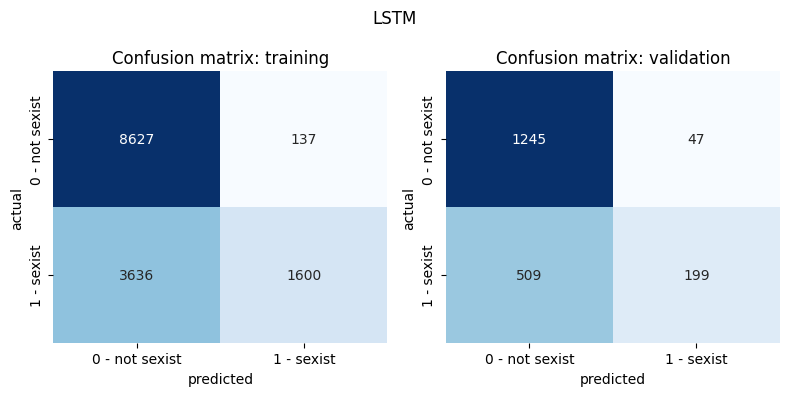

In [17]:
y_train_alos = convert_labels_to_int(y_train_alos)
y_train_balanced_alos = convert_labels_to_int(y_train_balanced_alos)
y_val_alos = convert_labels_to_int(y_val_alos)

rnn = LSTM_Model()
rnn.train(X_train, y_train_alos, X_val, y_val_alos)
res = rnn.evaluate({"training": X_train, "validation": X_val}, [y_train_alos, y_val_alos], model_name="LSTM")
for res_x in res:
    results.loc[len(results)] = res_x + ['at least one sexist']


Epoch 1/200
313/313 [==============================] - 7s 20ms/step - loss: 0.6796 - accuracy: 0.5857 - val_loss: 0.7529 - val_accuracy: 0.3540
Epoch 2/200
313/313 [==============================] - 6s 20ms/step - loss: 0.6793 - accuracy: 0.5857 - val_loss: 0.7401 - val_accuracy: 0.3540
Epoch 3/200
313/313 [==============================] - 10s 32ms/step - loss: 0.6605 - accuracy: 0.6050 - val_loss: 0.6606 - val_accuracy: 0.6565
Epoch 4/200
313/313 [==============================] - 13s 41ms/step - loss: 0.5018 - accuracy: 0.7680 - val_loss: 0.5544 - val_accuracy: 0.7280
Epoch 5/200
313/313 [==============================] - 13s 42ms/step - loss: 0.3715 - accuracy: 0.8442 - val_loss: 0.5460 - val_accuracy: 0.7310
Epoch 6/200
313/313 [==============================] - 14s 44ms/step - loss: 0.3070 - accuracy: 0.8807 - val_loss: 0.6051 - val_accuracy: 0.6945
Epoch 7/200
313/313 [==============================] - 13s 41ms/step - loss: 0.2580 - accuracy: 0.9030 - val_loss: 0.6891 - val_accu

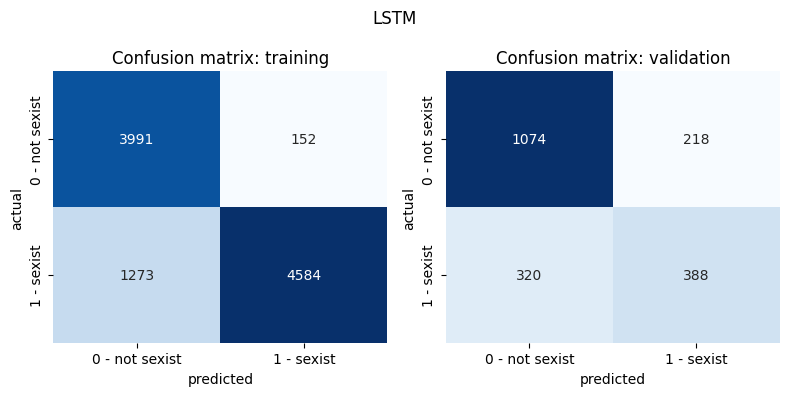

In [18]:
rnn_bal = LSTM_Model()
rnn_bal.train(X_balanced, y_train_balanced_alos, X_val, y_val_alos)

res = rnn_bal.evaluate({"training": X_balanced, "validation": X_val}, [y_train_balanced_alos, y_val_alos], model_name="LSTM")
for res_x in res:
    balanced_results.loc[len(balanced_results)] = res_x + ['at least one sexist']

### Results for different aggregation types

In [19]:
results.set_index(['Model', 'Aggregation Type']).sort_index()

Dataset  Accuracy  Balanced_Accuracy  \
Model       Aggregation Type                                               
LSTM        at least one sexist    training  0.730500           0.644972   
            at least one sexist  validation  0.722000           0.622348   
            majority voting        training  0.883500           0.779555   
            majority voting      validation  0.831500           0.683981   
            original               training  0.856643           0.725076   
            original             validation  0.815000           0.652872   
Naive Bayes at least one sexist    training  0.794429           0.776683   
            at least one sexist  validation  0.724000           0.689974   
            majority voting        training  0.857286           0.788316   
            majority voting      validation  0.816000           0.720272   
            original               training  0.861929           0.794156   
            original             validation  0.809500           0.712808   

                                 Precision    Recall  
Model       Aggregation Type                          
LSTM        at least one sexist   0.921128  0.305577  
            at least one sexist   0.808943  0.281073  
            majority voting       0.911874  0.577047  
            majority voting       0.793388  0.400835  
            original              0.886604  0.469394  
            original              0.773585  0.337449  
Naive Bayes at least one sexist   0.734021  0.706264  
            at least one sexist   0.618902  0.573446  
            majority voting       0.731211  0.653948  
            majority voting       0.637717  0.536534  
            original              0.741192  0.662448  
            original              0.629630  0.524691

In [20]:
balanced_results.set_index(['Model', 'Aggregation Type']).sort_index()

Dataset  Accuracy  Balanced_Accuracy  \
Model       Aggregation Type                                               
LSTM        at least one sexist    training    0.8575           0.872982   
            at least one sexist  validation    0.7310           0.689646   
            majority voting        training    0.9190           0.916157   
            majority voting      validation    0.7935           0.716921   
            original               training    0.5000           0.500000   
            original             validation    0.7570           0.500000   
Naive Bayes at least one sexist    training    0.8165           0.806019   
            at least one sexist  validation    0.6450           0.654685   
            majority voting        training    0.8365           0.835675   
            majority voting      validation    0.7280           0.687445   
            original               training    0.8318           0.831800   
            original             validation    0.7030           0.675297   

                                 Precision    Recall  
Model       Aggregation Type                          
LSTM        at least one sexist   0.967905  0.782653  
            at least one sexist   0.640264  0.548023  
            majority voting       0.940617  0.879800  
            majority voting       0.568750  0.569937  
            original              0.000000  0.000000  
            original              0.000000  0.000000  
Naive Bayes at least one sexist   0.827738  0.867167  
            at least one sexist   0.498975  0.687853  
            majority voting       0.821028  0.825125  
            majority voting       0.449923  0.609603  
            original              0.821014  0.848600  
            original              0.424157  0.621399